### In this notebook we perform federated learning

In federated learning each base station has access only to it's private dataset, however they collaborate together to train a model that has satifactory results on data from any other base station.

In [41]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [42]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch
from matplotlib import pyplot as plt

from argparse import Namespace

In [43]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [44]:
from ml.utils.train_utils import train, test

In [45]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [46]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [47]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("使用设备为：", device)


使用设备为： mps


In [48]:
args = Namespace(
    data_path='../dataset/cluster_split/cluster_3.csv', # dataset
    data_path_test=None , # test dataset
    test_size=0.2, # validation size
    targets=['power_output'], # the target columns
    num_lags= 8, # the number of past observations to feed as input

    identifier='GSRN', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=20, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [49]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/cluster_split/cluster_3.csv', data_path_test=None, test_size=0.2, targets=['power_output'], num_lags=8, identifier='GSRN', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=None, criterion='mse', fl_rounds=20, fraction=1.0, aggregation='fedavg', epochs=3, lr=0.001, optimizer='adam', batch_size=128, local_early_stopping=False, local_patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [51]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [52]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [53]:
seed_all()

### The pre-processing method is almost equivalent to centralized learning. The only difference is that the scaling operations are performed individually on each base station. In contrast, in centralized learning the scaling is performed by considering the combined data from all base stations.

In [54]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None

    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [55]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers= make_preprocessing()

/Users/libowen/SD3rd/RP/paper/code/Federated-Time-Series-Forecasting-main_single/ml/utils/data_utils.py:26: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)
/Users/libowen/Library/Python/3.10/lib/python/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
INFO logger 2025-10-20 01:02:26,609 | data_utils.py:393 | Observations info in 570714700000004605
INFO logger 2025-10-20 01:02:26,609 | data_utils.py:394 | 	Total number of samples:  2777
INFO logger 2025-10-20 01:02:26,609 | data_utils.py:395 | 	Number of samples for training: 2222
INFO logger 2025-10-20 01:02:26,610 | data_utils.py:396 | 	Number of samples for validation:  555
INFO logger 2025-10-20 01:02:26,610 | data_utils.py:393 

In [56]:
X_train.head()


cluster_lag-8  power_output_lag-8  age_lag-8  \
time                                                                
2019-01-02 15:00:00            0.0            1.000000        0.0   
2019-01-02 18:00:00            0.0            0.999688        0.0   
2019-01-02 21:00:00            0.0            0.999676        0.0   
2019-01-03 00:00:00            0.0            0.998669        0.0   
2019-01-03 03:00:00            0.0            0.999372        0.0   

                     wind_dir_cos_lag-8  wind_dir_sin_lag-8  hour_cos_lag-8  \
time                                                                          
2019-01-02 15:00:00            0.742405            0.062690        0.146447   
2019-01-02 18:00:00            0.894005            0.192169        0.500000   
2019-01-02 21:00:00            0.909576            0.213212        0.853553   
2019-01-03 00:00:00            0.978152            0.353814        1.000000   
2019-01-03 03:00:00            0.993844            0.421783        0.853553   

                     hour_sin_lag-8  temperature_c_lag-8  wind_speed_lag-8  \
time                                                                         
2019-01-02 15:00:00        0.146447             0.265130          0.979900   
2019-01-02 18:00:00        0.000000             0.273775          0.964824   
2019-01-02 21:00:00        0.146447             0.262248          0.889447   
2019-01-03 00:00:00        0.500000             0.242075          0.994975   
2019-01-03 03:00:00        0.853553             0.221902          0.879397   

                     cluster_lag-7  ...  cluster_lag-1  power_output_lag-1  \
time                                ...                                      
2019-01-02 15:00:00            0.0  ...            0.0            0.980563   
2019-01-02 18:00:00            0.0  ...            0.0            0.787417   
2019-01-02 21:00:00            0.0  ...            0.0            0.428552   
2019-01-03 00:00:00            0.0  ...            0.0            0.028336   
2019-01-03 03:00:00            0.0  ...            0.0            0.124026   

                     age_lag-1  wind_dir_cos_lag-1  wind_dir_sin_lag-1  \
time                                                                     
2019-01-02 15:00:00        0.0            0.999315            0.473832   
2019-01-02 18:00:00        0.0            0.996273            0.439065   
2019-01-02 21:00:00        0.0            0.999315            0.473832   
2019-01-03 00:00:00        0.0            0.980631            0.362181   
2019-01-03 03:00:00        0.0            0.924024            0.235040   

                     hour_cos_lag-1  hour_sin_lag-1  temperature_c_lag-1  \
time                                                                       
2019-01-02 15:00:00        0.000000        0.500000             0.178674   
2019-01-02 18:00:00        0.146447        0.146447             0.184438   
2019-01-02 21:00:00        0.500000        0.000000             0.195965   
2019-01-03 00:00:00        0.853553        0.146447             0.198847   
2019-01-03 03:00:00        1.000000        0.500000             0.216138   

                     wind_speed_lag-1                GSRN  
time                                                       
2019-01-02 15:00:00          0.733668  570714700000004605  
2019-01-02 18:00:00          0.688442  570714700000004605  
2019-01-02 21:00:00          0.527638  570714700000004605  
2019-01-03 00:00:00          0.487437  570714700000004605  
2019-01-03 03:00:00          0.542714  570714700000004605  

[5 rows x 73 columns]

In [ ]:
power_output_lag_indices = [
    i for i, col in enumerate(X_train.columns)
    if col.startswith("power_output_lag")
]
print("power_output_lag is on these column indices:", power_output_lag_indices)

power_output_lag 在这些列索引位置上： [1, 10, 19, 28, 37, 46, 55, 64]


In [58]:
y_train.head()

power_output                GSRN
time                                                 
2019-01-02 15:00:00      0.787417  570714700000004605
2019-01-02 18:00:00      0.428552  570714700000004605
2019-01-02 21:00:00      0.028336  570714700000004605
2019-01-03 00:00:00      0.124026  570714700000004605
2019-01-03 03:00:00      0.271103  570714700000004605

In [59]:
x_scalers, y_scalers

({570714700000004605: MinMaxScaler(),
  570714700000005213: MinMaxScaler(),
  570715000000107078: MinMaxScaler(),
  570714700000106699: MinMaxScaler(),
  570714700000106682: MinMaxScaler(),
  570714700000004735: MinMaxScaler(),
  570714700000004742: MinMaxScaler(),
  570714700000004759: MinMaxScaler(),
  570714700000011832: MinMaxScaler(),
  570714700000012396: MinMaxScaler(),
  570714700000009648: MinMaxScaler(),
  570714700000009938: MinMaxScaler(),
  570714700000009662: MinMaxScaler(),
  570714700000014284: MinMaxScaler(),
  570714700000014291: MinMaxScaler(),
  570714700000014307: MinMaxScaler(),
  570715000000091681: MinMaxScaler(),
  570714700000010897: MinMaxScaler(),
  570714700000014314: MinMaxScaler(),
  570714700000014321: MinMaxScaler(),
  570714700000014338: MinMaxScaler(),
  570714700000000379: MinMaxScaler(),
  570714700000000362: MinMaxScaler(),
  570714700000000355: MinMaxScaler(),
  570714700000000348: MinMaxScaler(),
  570714700000000317: MinMaxScaler(),
  5707147000

### Postprocessing in a same manner with centalized learning

In [60]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [61]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)

In [62]:
client_X_train.keys()

dict_keys([570714700000004605, 570714700000005213, 570715000000107078, 570714700000106699, 570714700000106682, 570714700000004735, 570714700000004742, 570714700000004759, 570714700000011832, 570714700000012396, 570714700000009648, 570714700000009938, 570714700000009662, 570714700000014284, 570714700000014291, 570714700000014307, 570715000000091681, 570714700000010897, 570714700000014314, 570714700000014321, 570714700000014338, 570714700000000379, 570714700000000362, 570714700000000355, 570714700000000348, 570714700000000317, 570714700000000324, 570714700000000157, 570714700000000331, 570714700000004384, 570714700000013621, 570714700000012631, 570714700000012570, 570714700000012648, 570714700000013386, 570714700000013393, 570714700000013409, 570714700000012327, 570714700000005138, 570714700000005121, 570714700000005114, 570714700000005107, 570714700000011900, 570714700000013119, 570714700000013188, 570714700000013898, 570714700000013102, 570714700000013881, 570714700000013096, 570714700

In [63]:
client_X_val.keys()

dict_keys([570714700000004605, 570714700000005213, 570715000000107078, 570714700000106699, 570714700000106682, 570714700000004735, 570714700000004742, 570714700000004759, 570714700000011832, 570714700000012396, 570714700000009648, 570714700000009938, 570714700000009662, 570714700000014284, 570714700000014291, 570714700000014307, 570715000000091681, 570714700000010897, 570714700000014314, 570714700000014321, 570714700000014338, 570714700000000379, 570714700000000362, 570714700000000355, 570714700000000348, 570714700000000317, 570714700000000324, 570714700000000157, 570714700000000331, 570714700000004384, 570714700000013621, 570714700000012631, 570714700000012570, 570714700000012648, 570714700000013386, 570714700000013393, 570714700000013409, 570714700000012327, 570714700000005138, 570714700000005121, 570714700000005114, 570714700000005107, 570714700000011900, 570714700000013119, 570714700000013188, 570714700000013898, 570714700000013102, 570714700000013881, 570714700000013096, 570714700

In [64]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: 570714700000004605
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000005213
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570715000000107078
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000106699
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000106682
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000004735
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000004742
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000004759
X_train shape: (2214

In [65]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [66]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [67]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                #   exogenous_dim=exogenous_dim,
                    exogenous_dim=0,
                  seed=args.seed)

9 0


In [68]:
model

LSTM(
  (lstm): LSTM(9, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Fit function initiates the training process of every base station local model and then performs parameters aggregation on a central server for N specified federated epochs.

In [69]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=  [1], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=True
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
 
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                #exogenous_data=tmp_exogenous_data_train,
                exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                # exogenous_data=tmp_exogenous_data_val,
                 exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [70]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

In [71]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2025-10-20 01:02:39,227 | server.py:62 | Initializing client manager...
INFO logger 2025-10-20 01:02:39,228 | server.py:69 | Registering clients...
INFO logger 2025-10-20 01:02:39,228 | client_manager.py:66 | Registered client with id: 570714700000004605
INFO logger 2025-10-20 01:02:39,228 | client_manager.py:66 | Registered client with id: 570714700000005213
INFO logger 2025-10-20 01:02:39,228 | client_manager.py:66 | Registered client with id: 570715000000107078
INFO logger 2025-10-20 01:02:39,229 | client_manager.py:66 | Registered client with id: 570714700000106699
INFO logger 2025-10-20 01:02:39,229 | client_manager.py:66 | Registered client with id: 570714700000106682
INFO logger 2025-10-20 01:02:39,229 | client_manager.py:66 | Registered client with id: 570714700000004735
INFO logger 2025-10-20 01:02:39,229 | client_manager.py:66 | Registered client with id: 570714700000004742
INFO logger 2025-10-20 01:02:39,230 | client_manager.py:66 | Registered client with id: 570

In [72]:
global_model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0007,  0.1249, -0.0727,  ...,  0.0411,  0.1041,  0.0844],
                      [ 0.0234,  0.0810, -0.0174,  ...,  0.0385,  0.0346,  0.1417],
                      [-0.0599,  0.0871,  0.0321,  ...,  0.1040,  0.1212,  0.2620],
                      ...,
                      [-0.0457,  0.0340, -0.0705,  ...,  0.1516, -0.0389,  0.1938],
                      [ 0.0744,  0.1055, -0.0551,  ..., -0.0474, -0.0526,  0.0353],
                      [-0.0855, -0.0944, -0.0668,  ...,  0.0335, -0.1137, -0.0205]])),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0825,  0.1466,  0.0092,  ..., -0.0954, -0.1071,  0.1546],
                      [-0.0402,  0.0430, -0.0300,  ..., -0.0018,  0.0509,  0.0146],
                      [-0.1139,  0.0466, -0.0979,  ..., -0.1530, -0.0756,  0.0807],
                      ...,
                      [ 0.0244,  0.1636, -0.0030,  ..., -0.0436, -0.0755,  0.0909],
                      [-0.0811,  

In [73]:
history


History (client, train losses):
	570714700000012839: {1: 0.00016940720089102986, 2: 0.00012939735046523104, 3: 0.00013174372830351624, 4: 0.00011210542932731564, 5: 0.00010445457104973784, 6: 9.973797704873047e-05, 7: 9.733372302296847e-05, 8: 9.962466571483401e-05, 9: 9.885456605689043e-05, 10: 9.782286171566665e-05, 11: 9.736752805536463e-05, 12: 9.655159399209522e-05, 13: 9.61752320903117e-05, 14: 9.295811044605821e-05, 15: 9.253562872685902e-05, 16: 9.211555397593986e-05, 17: 9.171158944398784e-05, 18: 9.131310789491696e-05, 19: 9.09613827142491e-05, 20: 9.061101855173398e-05}
	570714700000010606: {1: 0.0001791218172021836, 2: 0.00016146429116957987, 3: 0.00013543402585987585, 4: 0.0001227068079613627, 5: 0.00011409236187184299, 6: 0.00010802299217527098, 7: 0.0001047196936420928, 8: 0.00010272535594733804, 9: 0.00010197664011192408, 10: 0.0001011827477702388, 11: 0.00010099499877592735, 12: 0.000100484604769754, 13: 0.00010014752404765977, 14: 9.984728125577696e-05, 15: 9.9553351

In [74]:
import h5py
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# extract MinMaxScaler attributes
def get_minmax_attrs(scaler: MinMaxScaler):
    return {
        "min_": scaler.min_,
        "scale_": scaler.scale_,
        "data_min_": scaler.data_min_,
        "data_max_": scaler.data_max_,
        "data_range_": scaler.data_range_,
        "n_features_in_": np.array([scaler.n_features_in_]),
        "n_samples_seen_": np.array([scaler.n_samples_seen_]),
        "feature_names_in_": getattr(scaler, "feature_names_in_", None)
    }

# process a dict of MinMaxScalers
def build_scaler_state_dict(scaler_dict):
    state_dict = {}
    for client_id, scaler in scaler_dict.items():
        state_dict[client_id] = get_minmax_attrs(scaler)
    return state_dict

# save the scalers to h5 file
class ScalerSerializer:
    def __init__(self, x_scaler_state, y_scaler_state, save_path: str):
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        with h5py.File(self.save_path, "w") as f:
            # save x_scalers
            x_group = f.create_group("x_scaler", track_order=True)
            for client_id, attrs in self.x_scaler.items():
                client_group = x_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

            # save y_scalers
            y_group = f.create_group("y_scaler", track_order=True)
            for client_id, attrs in self.y_scaler.items():
                client_group = y_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

x_scaler_attrs = build_scaler_state_dict(x_scalers)
y_scaler_attrs = build_scaler_state_dict(y_scalers)

scaler_serializer = ScalerSerializer(
    x_scaler_attrs,
    y_scaler_attrs,
    save_path="model_checkpoint/scalers_cluster3.h5"
)
scaler_serializer.save()

print(" Scalers saved to model_checkpoint/scalers_cluster3.h5")

 Scalers saved to model_checkpoint/scalers_cluster3.h5


In [75]:
import matplotlib.pyplot as plt

def plot_fl_training_metrics(history):
    metrics_to_plot = ["MSE", "RMSE", "MAE", "R^2", "NRMSE"]
    rounds = list(range(1, len(next(iter(history.global_test_metrics.values()))) + 1))

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in history.global_test_metrics:
            plt.subplot(2, 3, i)
            plt.plot(rounds, history.global_test_metrics[metric], marker='o', label=f"Test {metric.upper()}")
            if metric in history.global_train_metrics:
                plt.plot(rounds, history.global_train_metrics[metric], marker='x', label=f"Train {metric.upper()}")
            plt.title(metric.upper())
            plt.xlabel("Round")
            plt.ylabel(metric.upper())
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.show()

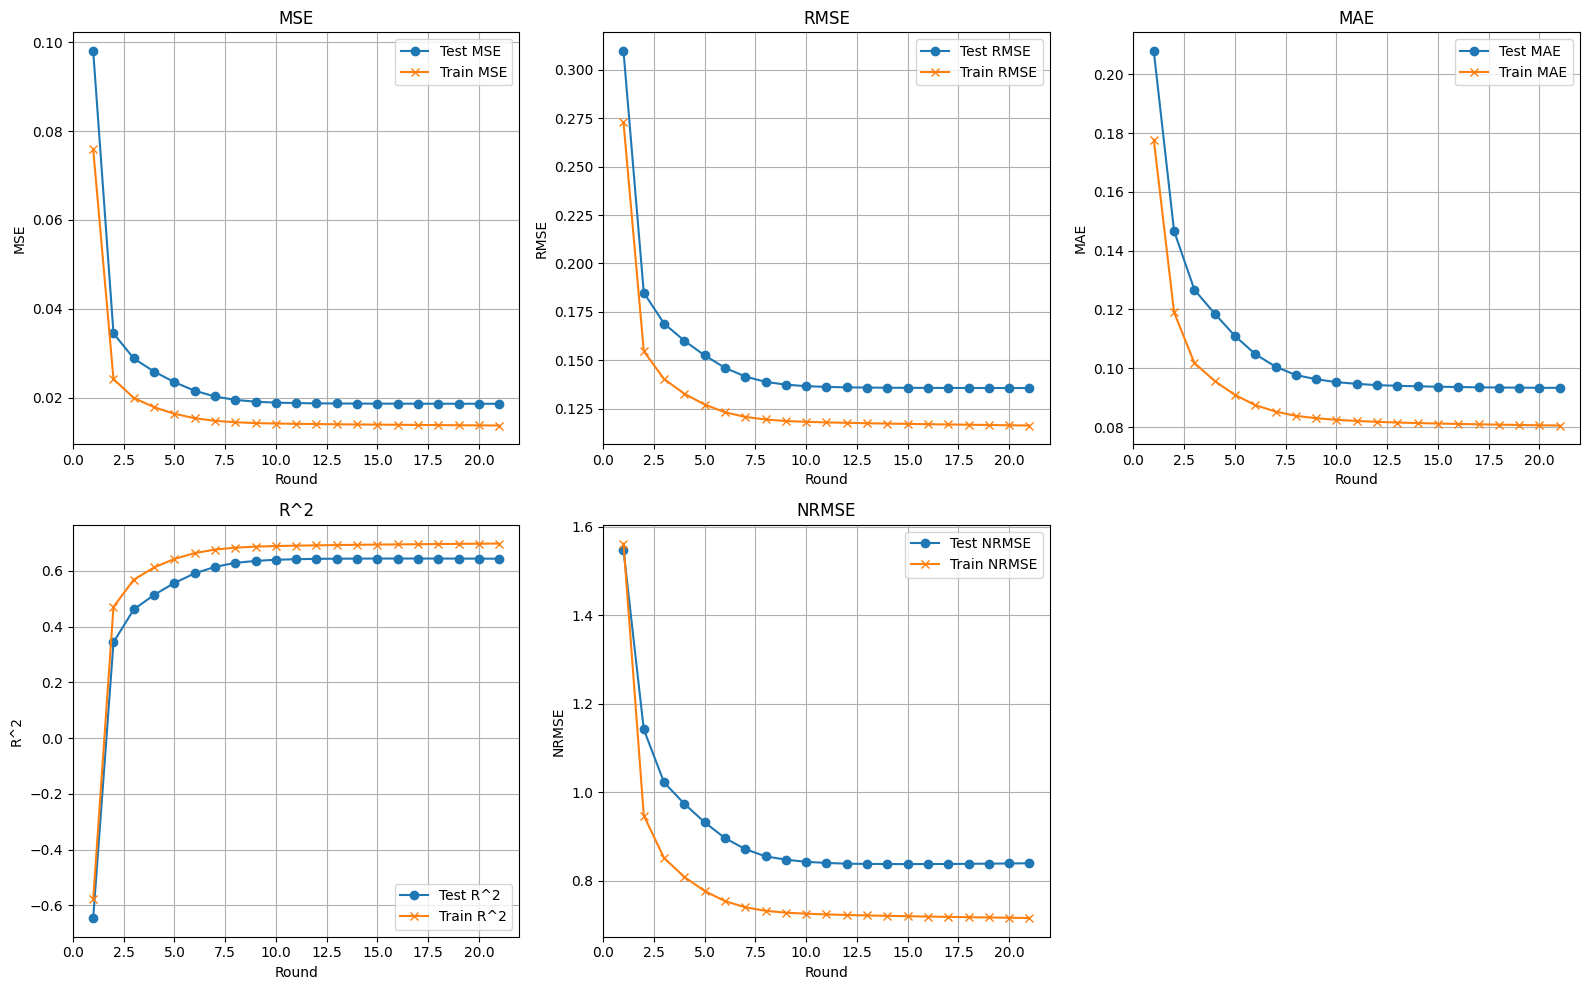

In [76]:
plot_fl_training_metrics(history)

In [77]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [78]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

### During the inference stage we inverse the transformations we applied during preprocessing

In [79]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scalers used to transform the targets
    idxs=[1],
    apply_round=True, # round to closest integer
    round_dimensions=[0], # the dimensions to apply rounding
    plot=True, # plot predictions
    plot_clients: list = None,  # 指定要画图的client，比如 ['GSRN_001', 'GSRN_002']
    max_plot_clients: int = 5,
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            if (plot_clients is not None and cid not in plot_clients):
                continue
            if plot_clients is None and cids.index(cid) >= max_plot_clients:
                continue

            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on 570714700000004605
Prediction on 570714700000005213
Prediction on 570715000000107078
Prediction on 570714700000106699
Prediction on 570714700000106682
Prediction on 570714700000004735
Prediction on 570714700000004742
Prediction on 570714700000004759
Prediction on 570714700000011832
Prediction on 570714700000012396
Prediction on 570714700000009648
Prediction on 570714700000009938
Prediction on 570714700000009662
Prediction on 570714700000014284
Prediction on 570714700000014291
Prediction on 570714700000014307
Prediction on 570715000000091681
Prediction on 570714700000010897
Prediction on 570714700000014314
Prediction on 570714700000014321
Prediction on 570714700000014338
Prediction on 570714700000000379
Prediction on 570714700000000362
Prediction on 570714700000000355
Prediction on 570714700000000348
Prediction on 570714700000000317
Prediction on 570714700000000324
Prediction on 570714700000000157
Prediction on 570714700000000331
Prediction on 570714700000004384
Prediction

INFO logger 2025-10-20 01:37:41,621 | helpers.py:60 | Metrics for dimension: 0
	mse: 5403.49853515625, rmse: 73.50849294575593, mae: 49.32207107543945, r^2: 0.7044750452041626, nrmse: 0.6838213853304441
INFO logger 2025-10-20 01:37:41,622 | helpers.py:60 | Metrics for dimension: 0
	mse: 6699.5810546875, rmse: 81.85096856291622, mae: 55.85560989379883, r^2: 0.6798211336135864, nrmse: 0.6801375158833418



Final Prediction on 570714700000004605 (Inference Stage)
[Train]: mse: 5403.49853515625, rmse: 73.50849294575593, mae 49.32207107543945, r2: 0.7044750452041626, nrmse: 0.6838213853304441
[Val]: mse: 6699.5810546875, rmse: 81.85096856291622, mae 55.85560989379883, r2: 0.6798211336135864, nrmse: 0.6801375158833418




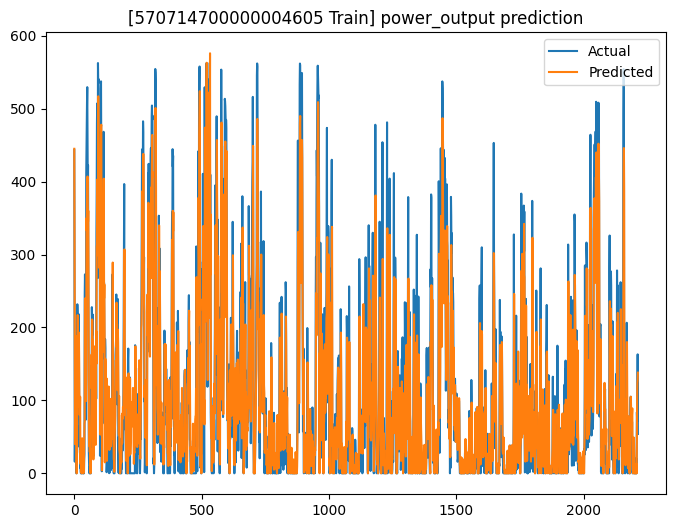

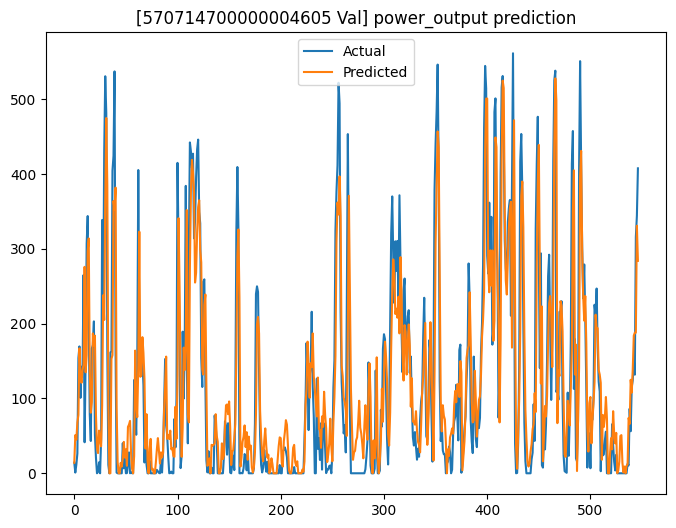

INFO logger 2025-10-20 01:37:41,738 | helpers.py:60 | Metrics for dimension: 0
	mse: 3904.159912109375, rmse: 62.48327705962112, mae: 41.5554313659668, r^2: 0.6955305933952332, nrmse: 0.696908918742061
INFO logger 2025-10-20 01:37:41,740 | helpers.py:60 | Metrics for dimension: 0
	mse: 5485.95849609375, rmse: 74.06725657194109, mae: 51.69020080566406, r^2: 0.6768625974655151, nrmse: 0.6595523380742404



Final Prediction on 570714700000005213 (Inference Stage)
[Train]: mse: 3904.159912109375, rmse: 62.48327705962112, mae 41.5554313659668, r2: 0.6955305933952332, nrmse: 0.696908918742061
[Val]: mse: 5485.95849609375, rmse: 74.06725657194109, mae 51.69020080566406, r2: 0.6768625974655151, nrmse: 0.6595523380742404




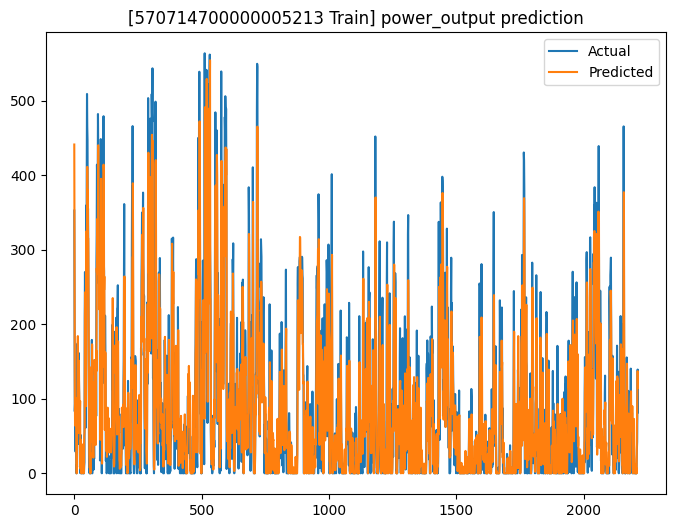

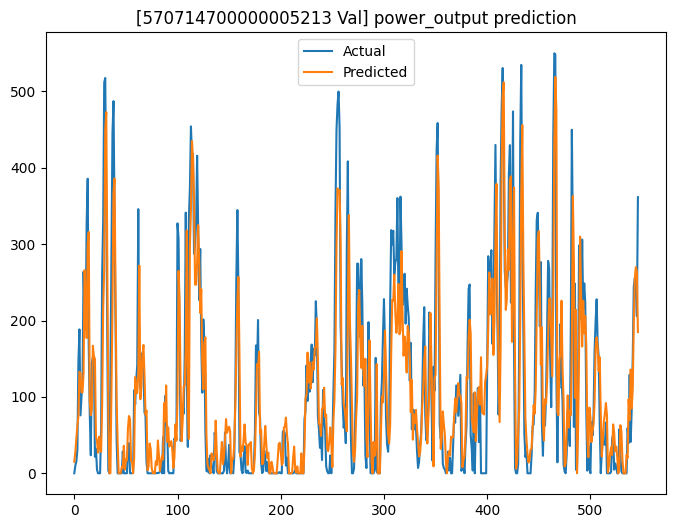

INFO logger 2025-10-20 01:37:41,847 | helpers.py:60 | Metrics for dimension: 0
	mse: 3627.8740234375, rmse: 60.231835630648845, mae: 39.86438751220703, r^2: 0.6958646178245544, nrmse: 0.6672397359830429
INFO logger 2025-10-20 01:37:41,848 | helpers.py:60 | Metrics for dimension: 0
	mse: 4504.501953125, rmse: 67.11558651405052, mae: 46.22937774658203, r^2: 0.6374835968017578, nrmse: 0.6653695179516897



Final Prediction on 570715000000107078 (Inference Stage)
[Train]: mse: 3627.8740234375, rmse: 60.231835630648845, mae 39.86438751220703, r2: 0.6958646178245544, nrmse: 0.6672397359830429
[Val]: mse: 4504.501953125, rmse: 67.11558651405052, mae 46.22937774658203, r2: 0.6374835968017578, nrmse: 0.6653695179516897




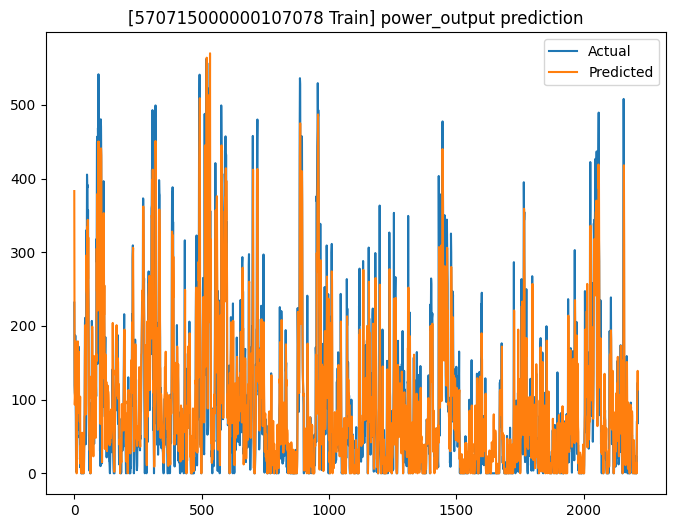

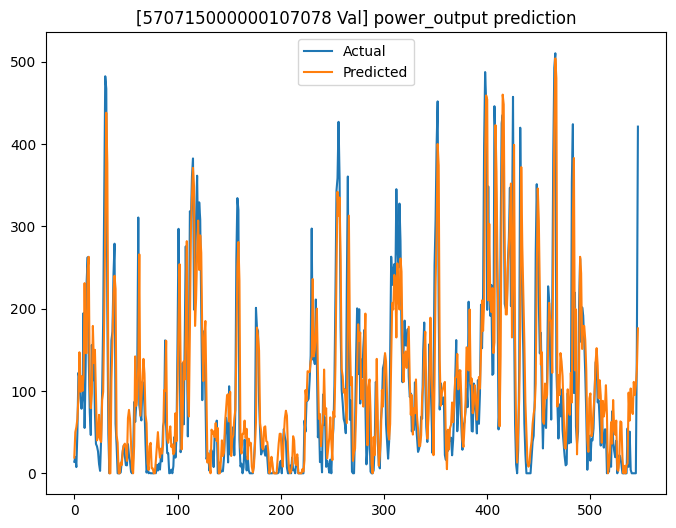

INFO logger 2025-10-20 01:37:41,950 | helpers.py:60 | Metrics for dimension: 0
	mse: 3546.369140625, rmse: 59.55139914918037, mae: 38.46630859375, r^2: 0.7171485424041748, nrmse: 0.7094833632739903
INFO logger 2025-10-20 01:37:41,952 | helpers.py:60 | Metrics for dimension: 0
	mse: 4635.06201171875, rmse: 68.08128973307387, mae: 45.94281005859375, r^2: 0.6824310421943665, nrmse: 0.6741069546647398



Final Prediction on 570714700000106699 (Inference Stage)
[Train]: mse: 3546.369140625, rmse: 59.55139914918037, mae 38.46630859375, r2: 0.7171485424041748, nrmse: 0.7094833632739903
[Val]: mse: 4635.06201171875, rmse: 68.08128973307387, mae 45.94281005859375, r2: 0.6824310421943665, nrmse: 0.6741069546647398




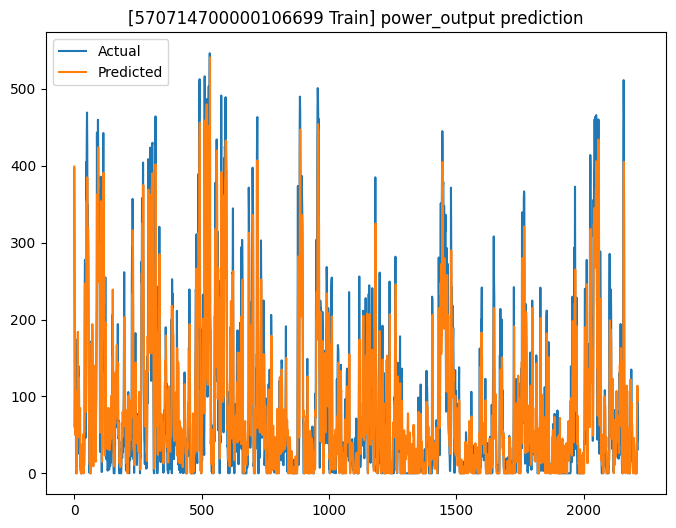

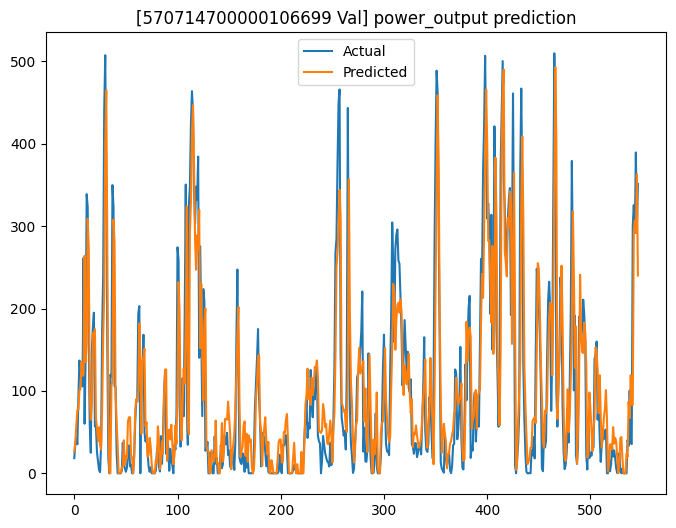

INFO logger 2025-10-20 01:37:42,054 | helpers.py:60 | Metrics for dimension: 0
	mse: 3844.0419921875, rmse: 62.00033864574854, mae: 40.40183639526367, r^2: 0.6993963122367859, nrmse: 0.6907564352716925
INFO logger 2025-10-20 01:37:42,055 | helpers.py:60 | Metrics for dimension: 0
	mse: 4379.599609375, rmse: 66.17854342137639, mae: 44.884620666503906, r^2: 0.6938403844833374, nrmse: 0.6595122223012938



Final Prediction on 570714700000106682 (Inference Stage)
[Train]: mse: 3844.0419921875, rmse: 62.00033864574854, mae 40.40183639526367, r2: 0.6993963122367859, nrmse: 0.6907564352716925
[Val]: mse: 4379.599609375, rmse: 66.17854342137639, mae 44.884620666503906, r2: 0.6938403844833374, nrmse: 0.6595122223012938




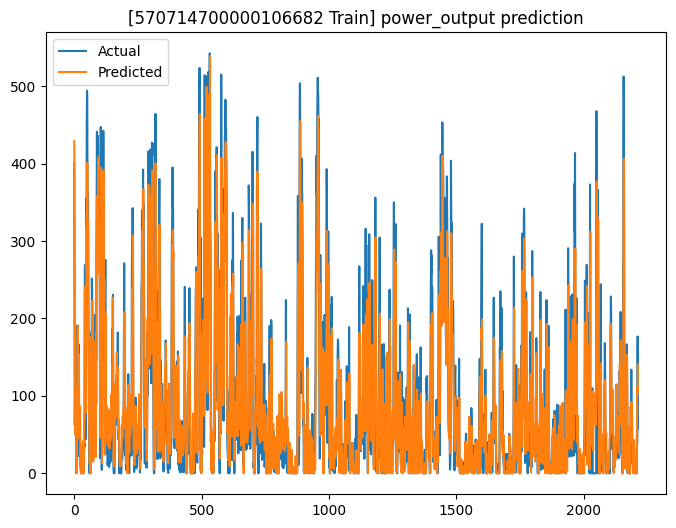

INFO logger 2025-10-20 01:37:42,218 | helpers.py:60 | Metrics for dimension: 0
	mse: 6136.6025390625, rmse: 78.33647004468928, mae: 54.07765197753906, r^2: 0.6550230979919434, nrmse: 0.5710950443126711
INFO logger 2025-10-20 01:37:42,219 | helpers.py:60 | Metrics for dimension: 0
	mse: 6251.89453125, rmse: 79.06892266402774, mae: 55.455753326416016, r^2: 0.7152513861656189, nrmse: 0.5090189154138268
INFO logger 2025-10-20 01:37:42,221 | helpers.py:60 | Metrics for dimension: 0
	mse: 5015.76806640625, rmse: 70.8220874191537, mae: 48.76371383666992, r^2: 0.6914136409759521, nrmse: 0.5716258047740851
INFO logger 2025-10-20 01:37:42,223 | helpers.py:60 | Metrics for dimension: 0
	mse: 5821.7060546875, rmse: 76.30010520757818, mae: 52.637168884277344, r^2: 0.7171303033828735, nrmse: 0.5429544582554223
INFO logger 2025-10-20 01:37:42,225 | helpers.py:60 | Metrics for dimension: 0
	mse: 5664.56787109375, rmse: 75.26332354536139, mae: 51.784629821777344, r^2: 0.6919006109237671, nrmse: 0.56283


Final Prediction on 570714700000004735 (Inference Stage)
[Train]: mse: 6136.6025390625, rmse: 78.33647004468928, mae 54.07765197753906, r2: 0.6550230979919434, nrmse: 0.5710950443126711
[Val]: mse: 6251.89453125, rmse: 79.06892266402774, mae 55.455753326416016, r2: 0.7152513861656189, nrmse: 0.5090189154138268



Final Prediction on 570714700000004742 (Inference Stage)
[Train]: mse: 5015.76806640625, rmse: 70.8220874191537, mae 48.76371383666992, r2: 0.6914136409759521, nrmse: 0.5716258047740851
[Val]: mse: 5821.7060546875, rmse: 76.30010520757818, mae 52.637168884277344, r2: 0.7171303033828735, nrmse: 0.5429544582554223



Final Prediction on 570714700000004759 (Inference Stage)
[Train]: mse: 5664.56787109375, rmse: 75.26332354536139, mae 51.784629821777344, r2: 0.6919006109237671, nrmse: 0.5628392094906074
[Val]: mse: 6438.68798828125, rmse: 80.24143560705559, mae 54.924625396728516, r2: 0.7125576734542847, nrmse: 0.5242080087984995



Final Prediction on 570714700000011832 (Inferen

INFO logger 2025-10-20 01:37:42,266 | helpers.py:60 | Metrics for dimension: 0
	mse: 6876.28515625, rmse: 82.92336918052715, mae: 57.13066101074219, r^2: 0.7141125202178955, nrmse: 0.6503781985942824
INFO logger 2025-10-20 01:37:42,267 | helpers.py:60 | Metrics for dimension: 0
	mse: 5111.1884765625, rmse: 71.49257637379212, mae: 47.55170822143555, r^2: 0.7230198979377747, nrmse: 0.7348735160047908
INFO logger 2025-10-20 01:37:42,268 | helpers.py:60 | Metrics for dimension: 0
	mse: 6572.79150390625, rmse: 81.07275438707045, mae: 55.949798583984375, r^2: 0.7106290459632874, nrmse: 0.6939387964713982
INFO logger 2025-10-20 01:37:42,270 | helpers.py:60 | Metrics for dimension: 0
	mse: 3998.917724609375, rmse: 63.23699648630836, mae: 43.665863037109375, r^2: 0.6909078359603882, nrmse: 0.7675078396674146
INFO logger 2025-10-20 01:37:42,271 | helpers.py:60 | Metrics for dimension: 0
	mse: 5523.0849609375, rmse: 74.31746067336734, mae: 52.76319122314453, r^2: 0.6577547192573547, nrmse: 0.7262


Final Prediction on 570714700000014321 (Inference Stage)
[Train]: mse: 5319.9052734375, rmse: 72.93768075170405, mae 49.12478256225586, r2: 0.7237735986709595, nrmse: 0.7120261674282412
[Val]: mse: 6876.28515625, rmse: 82.92336918052715, mae 57.13066101074219, r2: 0.7141125202178955, nrmse: 0.6503781985942824



Final Prediction on 570714700000014338 (Inference Stage)
[Train]: mse: 5111.1884765625, rmse: 71.49257637379212, mae 47.55170822143555, r2: 0.7230198979377747, nrmse: 0.7348735160047908
[Val]: mse: 6572.79150390625, rmse: 81.07275438707045, mae 55.949798583984375, r2: 0.7106290459632874, nrmse: 0.6939387964713982



Final Prediction on 570714700000000379 (Inference Stage)
[Train]: mse: 3998.917724609375, rmse: 63.23699648630836, mae 43.665863037109375, r2: 0.6909078359603882, nrmse: 0.7675078396674146
[Val]: mse: 5523.0849609375, rmse: 74.31746067336734, mae 52.76319122314453, r2: 0.6577547192573547, nrmse: 0.7262951921711729



Final Prediction on 570714700000000362 (Inferenc

INFO logger 2025-10-20 01:37:42,439 | helpers.py:60 | Metrics for dimension: 0
	mse: 6024.6640625, rmse: 77.6187094874683, mae: 52.59811782836914, r^2: 0.6904604434967041, nrmse: 0.8146320181378909
INFO logger 2025-10-20 01:37:42,441 | helpers.py:60 | Metrics for dimension: 0
	mse: 4568.69091796875, rmse: 67.59209212599319, mae: 44.52301788330078, r^2: 0.7334250807762146, nrmse: 0.762357389704552
INFO logger 2025-10-20 01:37:42,443 | helpers.py:60 | Metrics for dimension: 0
	mse: 6188.828125, rmse: 78.66910527646796, mae: 52.17179489135742, r^2: 0.6988399028778076, nrmse: 0.7854416880068934
INFO logger 2025-10-20 01:37:42,444 | helpers.py:60 | Metrics for dimension: 0
	mse: 4584.5908203125, rmse: 67.70960655854161, mae: 45.97842025756836, r^2: 0.7095457315444946, nrmse: 0.7559781574725788
INFO logger 2025-10-20 01:37:42,452 | helpers.py:60 | Metrics for dimension: 0
	mse: 6599.3837890625, rmse: 81.23659144168039, mae: 55.55887985229492, r^2: 0.6870632171630859, nrmse: 0.748419584327458


Final Prediction on 570714700000013300 (Inference Stage)
[Train]: mse: 4231.142578125, rmse: 65.04723343943999, mae 43.0140380859375, r2: 0.7375303506851196, nrmse: 0.7411854435943152
[Val]: mse: 6024.6640625, rmse: 77.6187094874683, mae 52.59811782836914, r2: 0.6904604434967041, nrmse: 0.8146320181378909



Final Prediction on 570714700000013294 (Inference Stage)
[Train]: mse: 4568.69091796875, rmse: 67.59209212599319, mae 44.52301788330078, r2: 0.7334250807762146, nrmse: 0.762357389704552
[Val]: mse: 6188.828125, rmse: 78.66910527646796, mae 52.17179489135742, r2: 0.6988399028778076, nrmse: 0.7854416880068934



Final Prediction on 570714700000013904 (Inference Stage)
[Train]: mse: 4584.5908203125, rmse: 67.70960655854161, mae 45.97842025756836, r2: 0.7095457315444946, nrmse: 0.7559781574725788
[Val]: mse: 6599.3837890625, rmse: 81.23659144168039, mae 55.55887985229492, r2: 0.6870632171630859, nrmse: 0.7484195843274581



Final Prediction on 570714700000011856 (Inference Stage)
[Tra

INFO logger 2025-10-20 01:37:42,468 | helpers.py:60 | Metrics for dimension: 0
	mse: 4207.51513671875, rmse: 64.86536160940406, mae: 43.961360931396484, r^2: 0.7184505462646484, nrmse: 0.8181823907335964
INFO logger 2025-10-20 01:37:42,469 | helpers.py:60 | Metrics for dimension: 0
	mse: 6786.99267578125, rmse: 82.38320627276684, mae: 55.260215759277344, r^2: 0.693183958530426, nrmse: 0.7328996042664646
INFO logger 2025-10-20 01:37:42,470 | helpers.py:60 | Metrics for dimension: 0
	mse: 3518.3896484375, rmse: 59.3160151092224, mae: 39.465362548828125, r^2: 0.7359931468963623, nrmse: 0.5685599311757946
INFO logger 2025-10-20 01:37:42,471 | helpers.py:60 | Metrics for dimension: 0
	mse: 5257.65673828125, rmse: 72.50970099428937, mae: 50.439815521240234, r^2: 0.7137004137039185, nrmse: 0.5941154715910467
INFO logger 2025-10-20 01:37:42,472 | helpers.py:60 | Metrics for dimension: 0
	mse: 3667.539794921875, rmse: 60.56021627208637, mae: 40.53166580200195, r^2: 0.7299641370773315, nrmse: 0.


Final Prediction on 570714700000013928 (Inference Stage)
[Train]: mse: 4207.51513671875, rmse: 64.86536160940406, mae 43.961360931396484, r2: 0.7184505462646484, nrmse: 0.8181823907335964
[Val]: mse: 6786.99267578125, rmse: 82.38320627276684, mae 55.260215759277344, r2: 0.693183958530426, nrmse: 0.7328996042664646



Final Prediction on 570714700000013843 (Inference Stage)
[Train]: mse: 3518.3896484375, rmse: 59.3160151092224, mae 39.465362548828125, r2: 0.7359931468963623, nrmse: 0.5685599311757946
[Val]: mse: 5257.65673828125, rmse: 72.50970099428937, mae 50.439815521240234, r2: 0.7137004137039185, nrmse: 0.5941154715910467



Final Prediction on 570714700000013836 (Inference Stage)
[Train]: mse: 3667.539794921875, rmse: 60.56021627208637, mae 40.53166580200195, r2: 0.7299641370773315, nrmse: 0.6108493658574032
[Val]: mse: 5472.52392578125, rmse: 73.97650928356413, mae 50.524147033691406, r2: 0.7037703394889832, nrmse: 0.5973590842217292



Final Prediction on 570714700000003165 (In

INFO logger 2025-10-20 01:37:42,642 | helpers.py:60 | Metrics for dimension: 0
	mse: 2774.446533203125, rmse: 52.6730152279431, mae: 35.439395904541016, r^2: 0.7233380079269409, nrmse: 0.6645433476150994
INFO logger 2025-10-20 01:37:42,643 | helpers.py:60 | Metrics for dimension: 0
	mse: 4168.83935546875, rmse: 64.56654981853026, mae: 43.466548919677734, r^2: 0.6029645204544067, nrmse: 0.7597304407237006
INFO logger 2025-10-20 01:37:42,645 | helpers.py:60 | Metrics for dimension: 0
	mse: 2391.658203125, rmse: 48.90458263930897, mae: 33.150413513183594, r^2: 0.7417282462120056, nrmse: 0.6166442061131175
INFO logger 2025-10-20 01:37:42,646 | helpers.py:60 | Metrics for dimension: 0
	mse: 3530.059326171875, rmse: 59.414302370488834, mae: 40.23232650756836, r^2: 0.6557415723800659, nrmse: 0.6792086292988574
INFO logger 2025-10-20 01:37:42,647 | helpers.py:60 | Metrics for dimension: 0
	mse: 3575.56689453125, rmse: 59.79604413781274, mae: 40.86429977416992, r^2: 0.7358269691467285, nrmse: 0


Final Prediction on 570714700000003387 (Inference Stage)
[Train]: mse: 2774.446533203125, rmse: 52.6730152279431, mae 35.439395904541016, r2: 0.7233380079269409, nrmse: 0.6645433476150994
[Val]: mse: 4168.83935546875, rmse: 64.56654981853026, mae 43.466548919677734, r2: 0.6029645204544067, nrmse: 0.7597304407237006



Final Prediction on 570714700000003394 (Inference Stage)
[Train]: mse: 2391.658203125, rmse: 48.90458263930897, mae 33.150413513183594, r2: 0.7417282462120056, nrmse: 0.6166442061131175
[Val]: mse: 3530.059326171875, rmse: 59.414302370488834, mae 40.23232650756836, r2: 0.6557415723800659, nrmse: 0.6792086292988574



Final Prediction on 570714700000012235 (Inference Stage)
[Train]: mse: 3575.56689453125, rmse: 59.79604413781274, mae 40.86429977416992, r2: 0.7358269691467285, nrmse: 0.5957109815909218
[Val]: mse: 4401.8271484375, rmse: 66.34626702714705, mae 44.88577651977539, r2: 0.7084466218948364, nrmse: 0.5855663360035044



Final Prediction on 570714700000105883 (Inf

INFO logger 2025-10-20 01:37:42,671 | helpers.py:60 | Metrics for dimension: 0
	mse: 5946.68212890625, rmse: 77.11473353974745, mae: 52.78334426879883, r^2: 0.7292650938034058, nrmse: 0.5570899322128781
INFO logger 2025-10-20 01:37:42,672 | helpers.py:60 | Metrics for dimension: 0
	mse: 7517.82568359375, rmse: 86.7053959312438, mae: 58.019554138183594, r^2: 0.7013188600540161, nrmse: 0.5518922233924624
INFO logger 2025-10-20 01:37:42,674 | helpers.py:60 | Metrics for dimension: 0
	mse: 3397.493408203125, rmse: 58.288021138164616, mae: 38.68694305419922, r^2: 0.671112060546875, nrmse: 0.6895506548014854
INFO logger 2025-10-20 01:37:42,675 | helpers.py:60 | Metrics for dimension: 0
	mse: 4112.4638671875, rmse: 64.12849497054722, mae: 44.007423400878906, r^2: 0.6500171422958374, nrmse: 0.6406318153252696
INFO logger 2025-10-20 01:37:42,676 | helpers.py:60 | Metrics for dimension: 0
	mse: 3845.0234375, rmse: 62.008252978938216, mae: 41.12105941772461, r^2: 0.7173508405685425, nrmse: 0.6256


Final Prediction on 570714700000012709 (Inference Stage)
[Train]: mse: 5020.8017578125, rmse: 70.85761608897451, mae 47.50910568237305, r2: 0.7426445484161377, nrmse: 0.6887492398513455
[Val]: mse: 6904.568359375, rmse: 83.09373237119031, mae 54.09020233154297, r2: 0.7250089645385742, nrmse: 0.6468327804527719



Final Prediction on 570714700000105838 (Inference Stage)
[Train]: mse: 5946.68212890625, rmse: 77.11473353974745, mae 52.78334426879883, r2: 0.7292650938034058, nrmse: 0.5570899322128781
[Val]: mse: 7517.82568359375, rmse: 86.7053959312438, mae 58.019554138183594, r2: 0.7013188600540161, nrmse: 0.5518922233924624



Final Prediction on 570714700000013935 (Inference Stage)
[Train]: mse: 3397.493408203125, rmse: 58.288021138164616, mae 38.68694305419922, r2: 0.671112060546875, nrmse: 0.6895506548014854
[Val]: mse: 4112.4638671875, rmse: 64.12849497054722, mae 44.007423400878906, r2: 0.6500171422958374, nrmse: 0.6406318153252696



Final Prediction on 570714700000003400 (Inferen

INFO logger 2025-10-20 01:37:42,845 | helpers.py:60 | Metrics for dimension: 0
	mse: 6556.1572265625, rmse: 80.97010081852746, mae: 55.86144256591797, r^2: 0.7188668251037598, nrmse: 0.5605474984834
INFO logger 2025-10-20 01:37:42,846 | helpers.py:60 | Metrics for dimension: 0
	mse: 4699.51513671875, rmse: 68.55300968388441, mae: 47.604644775390625, r^2: 0.7420201301574707, nrmse: 0.5727610379664967
INFO logger 2025-10-20 01:37:42,847 | helpers.py:60 | Metrics for dimension: 0
	mse: 6340.64892578125, rmse: 79.6281917776691, mae: 55.06459045410156, r^2: 0.7178653478622437, nrmse: 0.5415188490152882
INFO logger 2025-10-20 01:37:42,849 | helpers.py:60 | Metrics for dimension: 0
	mse: 4177.68505859375, rmse: 64.63501418421559, mae: 45.0237922668457, r^2: 0.7400199174880981, nrmse: 0.5613629249224256
INFO logger 2025-10-20 01:37:42,849 | helpers.py:60 | Metrics for dimension: 0
	mse: 5858.7548828125, rmse: 76.54250376628988, mae: 53.763973236083984, r^2: 0.7088738679885864, nrmse: 0.5364839


Final Prediction on 570714700000002205 (Inference Stage)
[Train]: mse: 5737.12646484375, rmse: 75.7438212981346, mae 50.43169021606445, r2: 0.6826727390289307, nrmse: 0.6568122266548397
[Val]: mse: 6556.1572265625, rmse: 80.97010081852746, mae 55.86144256591797, r2: 0.7188668251037598, nrmse: 0.5605474984834



Final Prediction on 570714700000002199 (Inference Stage)
[Train]: mse: 4699.51513671875, rmse: 68.55300968388441, mae 47.604644775390625, r2: 0.7420201301574707, nrmse: 0.5727610379664967
[Val]: mse: 6340.64892578125, rmse: 79.6281917776691, mae 55.06459045410156, r2: 0.7178653478622437, nrmse: 0.5415188490152882



Final Prediction on 570714700000002182 (Inference Stage)
[Train]: mse: 4177.68505859375, rmse: 64.63501418421559, mae 45.0237922668457, r2: 0.7400199174880981, nrmse: 0.5613629249224256
[Val]: mse: 5858.7548828125, rmse: 76.54250376628988, mae 53.763973236083984, r2: 0.7088738679885864, nrmse: 0.5364839386372633



Final Prediction on 570714700000012853 (Inference S

INFO logger 2025-10-20 01:37:42,872 | helpers.py:60 | Metrics for dimension: 0
	mse: 6235.21484375, rmse: 78.96337659795203, mae: 53.61908721923828, r^2: 0.6845880746841431, nrmse: 0.5781275979686537
INFO logger 2025-10-20 01:37:42,873 | helpers.py:60 | Metrics for dimension: 0
	mse: 6877.0390625, rmse: 82.92791485682008, mae: 58.23236846923828, r^2: 0.6800788640975952, nrmse: 0.5295392280469959
INFO logger 2025-10-20 01:37:42,874 | helpers.py:60 | Metrics for dimension: 0
	mse: 5083.36328125, rmse: 71.29770880785722, mae: 49.714115142822266, r^2: 0.7159130573272705, nrmse: 0.5389841340135642
INFO logger 2025-10-20 01:37:42,875 | helpers.py:60 | Metrics for dimension: 0
	mse: 5561.45361328125, rmse: 74.57515412844448, mae: 52.12803649902344, r^2: 0.7002798318862915, nrmse: 0.5143200134113043
INFO logger 2025-10-20 01:37:42,876 | helpers.py:60 | Metrics for dimension: 0
	mse: 6651.23193359375, rmse: 81.55508527120642, mae: 55.62681198120117, r^2: 0.6417193412780762, nrmse: 0.64131597929


Final Prediction on 570714700000010774 (Inference Stage)
[Train]: mse: 6235.21484375, rmse: 78.96337659795203, mae 53.61908721923828, r2: 0.6845880746841431, nrmse: 0.5781275979686537
[Val]: mse: 6877.0390625, rmse: 82.92791485682008, mae 58.23236846923828, r2: 0.6800788640975952, nrmse: 0.5295392280469959



Final Prediction on 570714700000012785 (Inference Stage)
[Train]: mse: 5083.36328125, rmse: 71.29770880785722, mae 49.714115142822266, r2: 0.7159130573272705, nrmse: 0.5389841340135642
[Val]: mse: 5561.45361328125, rmse: 74.57515412844448, mae 52.12803649902344, r2: 0.7002798318862915, nrmse: 0.5143200134113043



Final Prediction on 570714700000012778 (Inference Stage)
[Train]: mse: 6651.23193359375, rmse: 81.55508527120642, mae 55.62681198120117, r2: 0.6417193412780762, nrmse: 0.6413159792982885
[Val]: mse: 6352.86474609375, rmse: 79.70486024135386, mae 56.33584976196289, r2: 0.7066646814346313, nrmse: 0.596996344419815



Final Prediction on 570714700000009808 (Inference Stage

In [80]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scalers
)

It takes 33 min for 20 rounds, 17 min for 10 rounds